In [2]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Cargando modelo YOLOv11...
Usando dispositivo: cuda
Modelo cargado: YOLOv11x
Total de clases en el modelo: 80
🚀 DEMO: YOLOv11 para detección multiclase
🔍 ANÁLISIS MULTICLASE CON YOLOv11
Analizando imagen con YOLOv11: https://media.istockphoto.com/id/1397951495/es/foto/tr%C3%A1fico-pesado-de-la-gran-ciudad.jpg?s=612x612&w=0&k=20&c=nOcEfnKHmaoZBD0crYCzVKAL5hRp4hnQCTRvkR4MXLc=
Umbral de confianza: 0.05
Ejecutando detección...
Detectados 54 objetos

Objetos detectados por categoría:
  📂 vehicle: 54

Top 10 clases detectadas:
  🚗 car: 32 (conf: 0.487)
  🚛 truck: 21 (conf: 0.218)
  🚌 bus: 1 (conf: 0.223)


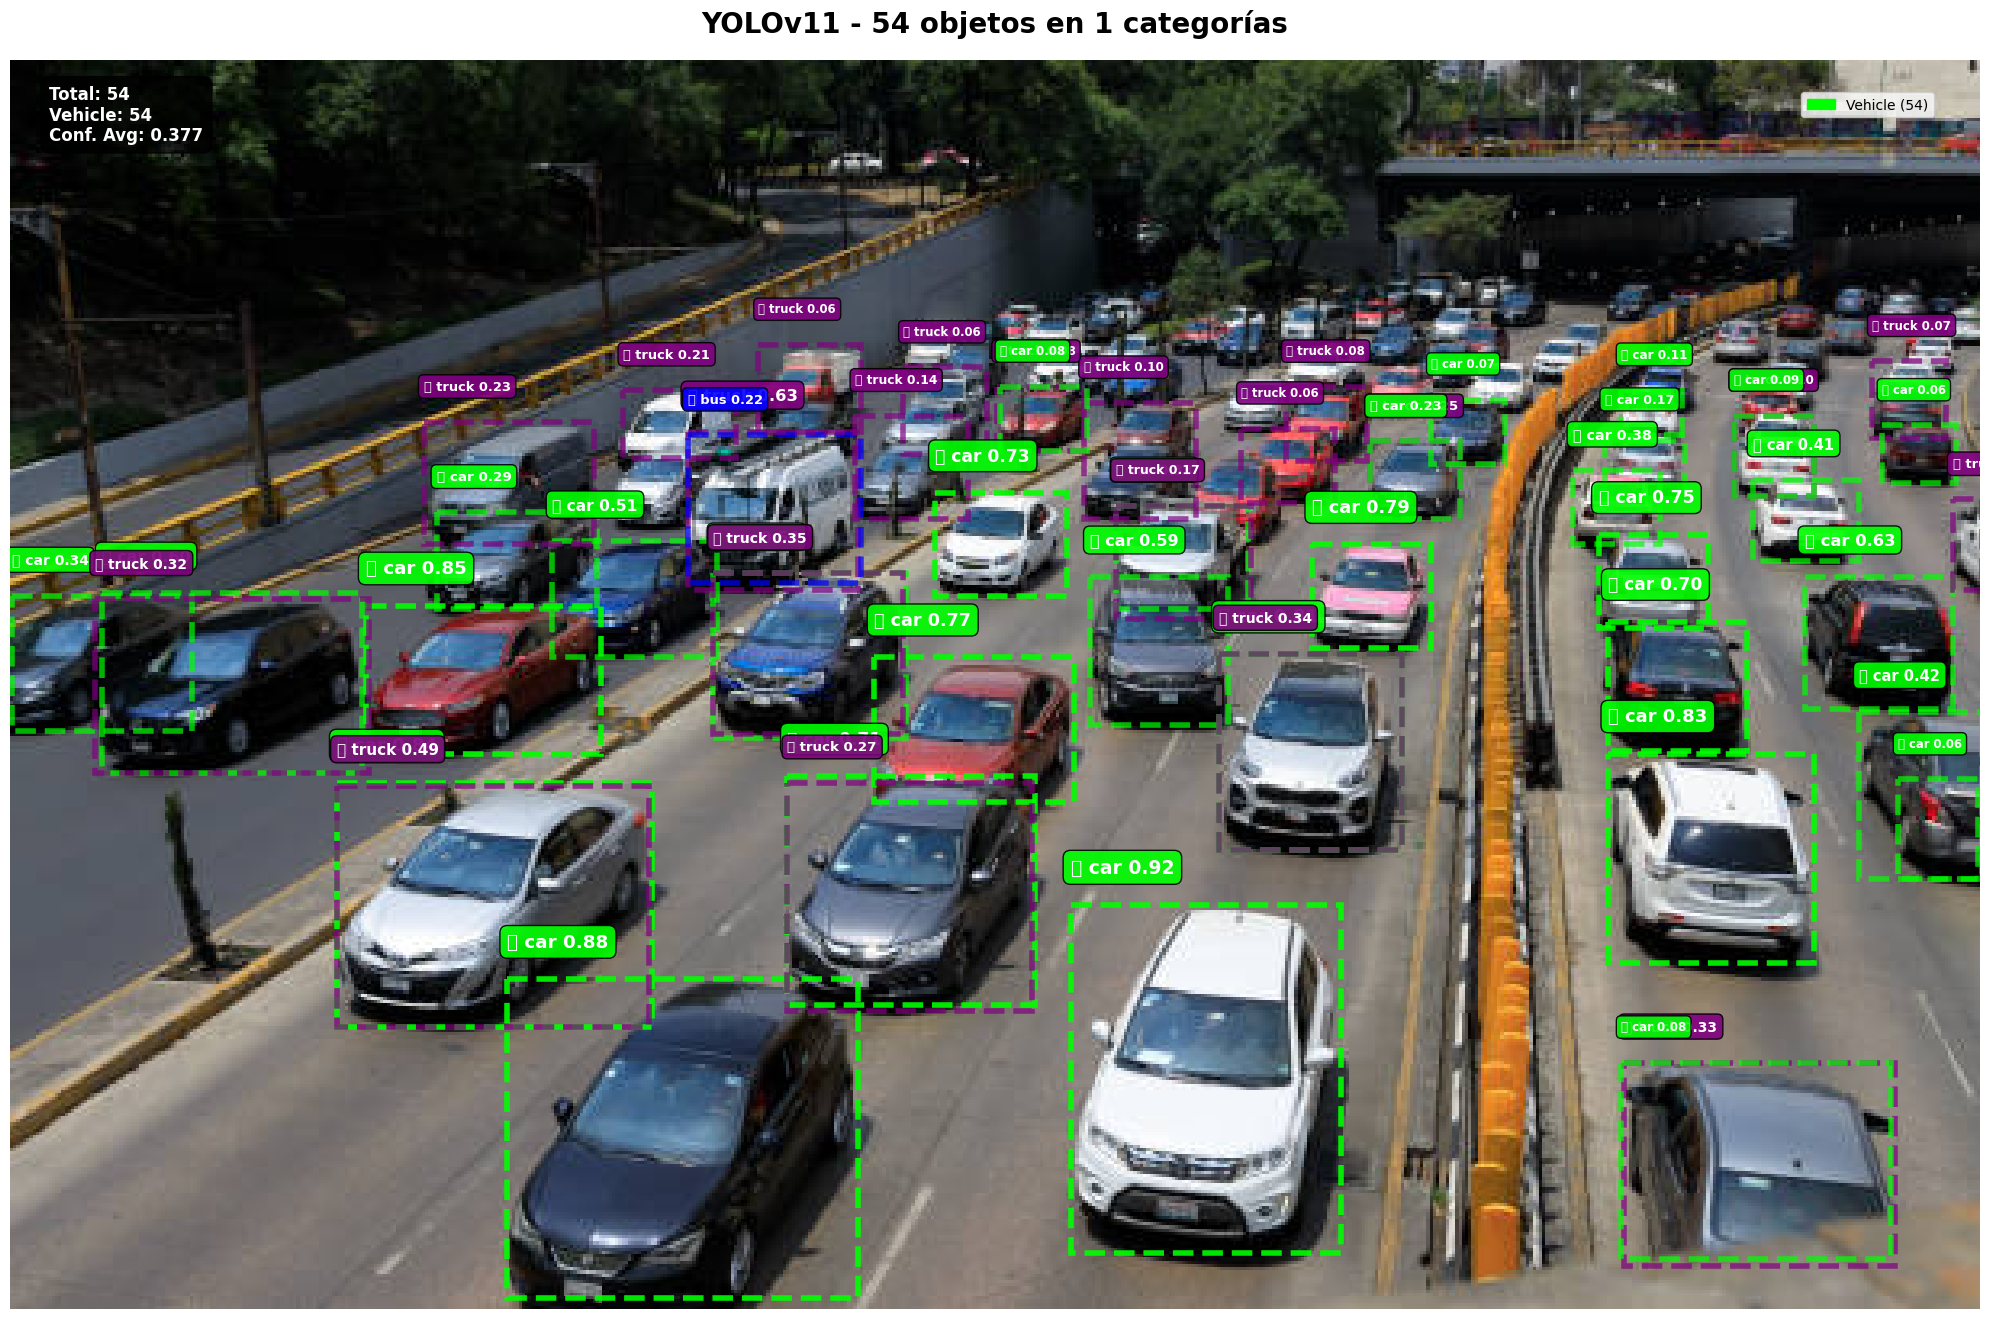


🎯 RESULTADOS:
📊 Total de objetos: 54
🏷️ Categorías detectadas: 1
📈 Confianza promedio: 0.377

📂 Por categoría:
   Vehicle: 54

🎭 Clases detectadas:
   🚌 bus
   🚗 car
   🚛 truck

📊 Distribución de confianza:
   muy_alta: 6
   alta: 8
   media: 7
   baja: 15
   muy_baja: 18


In [20]:
import torch
import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import random
import traceback
from ultralytics import YOLO

# Configuración específica para Google Colab
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configuración de parámetros
REQUEST_TIMEOUT = 15
MIN_REQUEST_DELAY = 0.5
MAX_REQUEST_DELAY = 2.0
CURRENT_DELAY = MIN_REQUEST_DELAY
BACKOFF_FACTOR = 1.5

# Configuración completa de clases YOLO con categorías
YOLO_CLASSES = {
    # Personas
    'person': {'id': 0, 'category': 'person', 'icon': '👤', 'color': '#FF0000'},

    # Vehículos
    'bicycle': {'id': 1, 'category': 'vehicle', 'icon': '🚲', 'color': '#FF00FF'},
    'car': {'id': 2, 'category': 'vehicle', 'icon': '🚗', 'color': '#00FF00'},
    'motorcycle': {'id': 3, 'category': 'vehicle', 'icon': '🏍️', 'color': '#FFFF00'},
    'airplane': {'id': 4, 'category': 'vehicle', 'icon': '✈️', 'color': '#00FFFF'},
    'bus': {'id': 5, 'category': 'vehicle', 'icon': '🚌', 'color': '#0000FF'},
    'train': {'id': 6, 'category': 'vehicle', 'icon': '🚂', 'color': '#FFA500'},
    'truck': {'id': 7, 'category': 'vehicle', 'icon': '🚛', 'color': '#800080'},
    'boat': {'id': 8, 'category': 'vehicle', 'icon': '⛵', 'color': '#008000'},

    # Señales de tráfico
    'traffic light': {'id': 9, 'category': 'traffic', 'icon': '🚦', 'color': '#FF4500'},
    'fire hydrant': {'id': 10, 'category': 'street', 'icon': '🚒', 'color': '#DC143C'},
    'stop sign': {'id': 11, 'category': 'traffic', 'icon': '🛑', 'color': '#8B0000'},
    'parking meter': {'id': 12, 'category': 'street', 'icon': '🅿️', 'color': '#4B0082'},
    'bench': {'id': 13, 'category': 'street', 'icon': '🪑', 'color': '#D2691E'},

    # Animales
    'bird': {'id': 14, 'category': 'animal', 'icon': '🐦', 'color': '#87CEEB'},
    'cat': {'id': 15, 'category': 'animal', 'icon': '🐱', 'color': '#FF69B4'},
    'dog': {'id': 16, 'category': 'animal', 'icon': '🐕', 'color': '#CD853F'},
    'horse': {'id': 17, 'category': 'animal', 'icon': '🐎', 'color': '#8B4513'},
    'sheep': {'id': 18, 'category': 'animal', 'icon': '🐑', 'color': '#F5F5DC'},
    'cow': {'id': 19, 'category': 'animal', 'icon': '🐄', 'color': '#000000'},
    'elephant': {'id': 20, 'category': 'animal', 'icon': '🐘', 'color': '#696969'},
    'bear': {'id': 21, 'category': 'animal', 'icon': '🐻', 'color': '#8B4513'},
    'zebra': {'id': 22, 'category': 'animal', 'icon': '🦓', 'color': '#000000'},
    'giraffe': {'id': 23, 'category': 'animal', 'icon': '🦒', 'color': '#DAA520'},

    # Objetos
    'backpack': {'id': 24, 'category': 'object', 'icon': '🎒', 'color': '#4169E1'},
    'umbrella': {'id': 25, 'category': 'object', 'icon': '☂️', 'color': '#000080'},
    'handbag': {'id': 26, 'category': 'object', 'icon': '👜', 'color': '#800000'},
    'tie': {'id': 27, 'category': 'object', 'icon': '👔', 'color': '#2F4F4F'},
    'suitcase': {'id': 28, 'category': 'object', 'icon': '🧳', 'color': '#8B4513'},

    # Deportes
    'frisbee': {'id': 29, 'category': 'sport', 'icon': '🥏', 'color': '#FF6347'},
    'skis': {'id': 30, 'category': 'sport', 'icon': '🎿', 'color': '#87CEEB'},
    'snowboard': {'id': 31, 'category': 'sport', 'icon': '🏂', 'color': '#4682B4'},
    'sports ball': {'id': 32, 'category': 'sport', 'icon': '⚽', 'color': '#FF4500'},
    'kite': {'id': 33, 'category': 'sport', 'icon': '🪁', 'color': '#FF1493'},
    'baseball bat': {'id': 34, 'category': 'sport', 'icon': '⚾', 'color': '#8B4513'},
    'baseball glove': {'id': 35, 'category': 'sport', 'icon': '🥎', 'color': '#CD853F'},
    'skateboard': {'id': 36, 'category': 'sport', 'icon': '🛹', 'color': '#FF6347'},
    'surfboard': {'id': 37, 'category': 'sport', 'icon': '🏄', 'color': '#00CED1'},
    'tennis racket': {'id': 38, 'category': 'sport', 'icon': '🎾', 'color': '#32CD32'},

    # Cocina
    'bottle': {'id': 39, 'category': 'kitchen', 'icon': '🍼', 'color': '#00BFFF'},
    'wine glass': {'id': 40, 'category': 'kitchen', 'icon': '🍷', 'color': '#800080'},
    'cup': {'id': 41, 'category': 'kitchen', 'icon': '☕', 'color': '#8B4513'},
    'fork': {'id': 42, 'category': 'kitchen', 'icon': '🍴', 'color': '#C0C0C0'},
    'knife': {'id': 43, 'category': 'kitchen', 'icon': '🔪', 'color': '#C0C0C0'},
    'spoon': {'id': 44, 'category': 'kitchen', 'icon': '🥄', 'color': '#C0C0C0'},
    'bowl': {'id': 45, 'category': 'kitchen', 'icon': '🥣', 'color': '#F5F5DC'},

    # Comida
    'banana': {'id': 46, 'category': 'food', 'icon': '🍌', 'color': '#FFFF00'},
    'apple': {'id': 47, 'category': 'food', 'icon': '🍎', 'color': '#FF0000'},
    'sandwich': {'id': 48, 'category': 'food', 'icon': '🥪', 'color': '#DEB887'},
    'orange': {'id': 49, 'category': 'food', 'icon': '🍊', 'color': '#FFA500'},
    'broccoli': {'id': 50, 'category': 'food', 'icon': '🥦', 'color': '#228B22'},
    'carrot': {'id': 51, 'category': 'food', 'icon': '🥕', 'color': '#FF8C00'},
    'hot dog': {'id': 52, 'category': 'food', 'icon': '🌭', 'color': '#D2691E'},
    'pizza': {'id': 53, 'category': 'food', 'icon': '🍕', 'color': '#FF6347'},
    'donut': {'id': 54, 'category': 'food', 'icon': '🍩', 'color': '#DDA0DD'},
    'cake': {'id': 55, 'category': 'food', 'icon': '🍰', 'color': '#FFB6C1'},

    # Muebles
    'chair': {'id': 56, 'category': 'furniture', 'icon': '🪑', 'color': '#8B4513'},
    'couch': {'id': 57, 'category': 'furniture', 'icon': '🛋️', 'color': '#CD853F'},
    'potted plant': {'id': 58, 'category': 'furniture', 'icon': '🪴', 'color': '#228B22'},
    'bed': {'id': 59, 'category': 'furniture', 'icon': '🛏️', 'color': '#F5F5DC'},
    'dining table': {'id': 60, 'category': 'furniture', 'icon': '🍽️', 'color': '#8B4513'},
    'toilet': {'id': 61, 'category': 'furniture', 'icon': '🚽', 'color': '#F5F5F5'},

    # Electrónicos
    'tv': {'id': 62, 'category': 'electronics', 'icon': '📺', 'color': '#000000'},
    'laptop': {'id': 63, 'category': 'electronics', 'icon': '💻', 'color': '#2F4F4F'},
    'mouse': {'id': 64, 'category': 'electronics', 'icon': '🖱️', 'color': '#696969'},
    'remote': {'id': 65, 'category': 'electronics', 'icon': '📱', 'color': '#000000'},
    'keyboard': {'id': 66, 'category': 'electronics', 'icon': '⌨️', 'color': '#2F4F4F'},
    'cell phone': {'id': 67, 'category': 'electronics', 'icon': '📱', 'color': '#000000'},
    'microwave': {'id': 68, 'category': 'electronics', 'icon': '📟', 'color': '#C0C0C0'},
    'oven': {'id': 69, 'category': 'electronics', 'icon': '🔥', 'color': '#FF4500'},
    'toaster': {'id': 70, 'category': 'electronics', 'icon': '🍞', 'color': '#C0C0C0'},
    'sink': {'id': 71, 'category': 'electronics', 'icon': '🚿', 'color': '#C0C0C0'},
    'refrigerator': {'id': 72, 'category': 'electronics', 'icon': '🧊', 'color': '#F5F5F5'},

    # Aplicaciones
    'book': {'id': 73, 'category': 'object', 'icon': '📚', 'color': '#8B4513'},
    'clock': {'id': 74, 'category': 'object', 'icon': '🕐', 'color': '#FFD700'},
    'vase': {'id': 75, 'category': 'object', 'icon': '🏺', 'color': '#DDA0DD'},
    'scissors': {'id': 76, 'category': 'object', 'icon': '✂️', 'color': '#C0C0C0'},
    'teddy bear': {'id': 77, 'category': 'object', 'icon': '🧸', 'color': '#8B4513'},
    'hair drier': {'id': 78, 'category': 'object', 'icon': '💨', 'color': '#C0C0C0'},
    'toothbrush': {'id': 79, 'category': 'object', 'icon': '🪥', 'color': '#00BFFF'}
}

# Cargar el modelo YOLOv11
print("Cargando modelo YOLOv11...")
try:
    model = YOLO('yolo11x.pt')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    use_gpu = torch.cuda.is_available()

    print(f"Usando dispositivo: {device}")
    print(f"Modelo cargado: YOLOv11x")

    # Obtener nombres de clases del modelo
    class_names = model.names
    print(f"Total de clases en el modelo: {len(class_names)}")

except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    traceback.print_exc()
    raise

def get_image_from_url(url, retry_count=0, max_retries=3):
    """Obtiene una imagen desde una URL con manejo de errores."""
    global CURRENT_DELAY

    time.sleep(CURRENT_DELAY + random.uniform(0, 0.1))

    try:
        response = requests.get(url, timeout=REQUEST_TIMEOUT)

        if response.status_code == 200:
            CURRENT_DELAY = max(MIN_REQUEST_DELAY, CURRENT_DELAY / 1.2)
            image = Image.open(BytesIO(response.content))
            return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        elif response.status_code == 429:
            print(f"Error 429 (Too Many Requests) para URL: {url}")
            CURRENT_DELAY = min(MAX_REQUEST_DELAY, CURRENT_DELAY * BACKOFF_FACTOR)

            if retry_count < max_retries:
                retry_wait = CURRENT_DELAY * 2
                print(f"Reintentando en {retry_wait:.2f} segundos...")
                time.sleep(retry_wait)
                return get_image_from_url(url, retry_count + 1, max_retries)
            else:
                print("Número máximo de reintentos alcanzado")
                return None
        else:
            print(f"Error al obtener imagen, código: {response.status_code}")
            return None

    except Exception as e:
        print(f"Error inesperado: {e}")
        return None

def preprocess_image(img_rgb):
    """Preprocesa la imagen para mejorar la detección."""
    img_enhanced = cv2.convertScaleAbs(img_rgb, alpha=1.1, beta=10)
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    img_enhanced = cv2.filter2D(img_enhanced, -1, kernel)
    return img_enhanced

def get_class_info(class_name):
    """Obtiene información de la clase (color, icono, categoría)."""
    if class_name in YOLO_CLASSES:
        return YOLO_CLASSES[class_name]
    else:
        # Clase no definida, usar valores por defecto
        return {
            'category': 'unknown',
            'icon': '❓',
            'color': '#808080'
        }

def detect_objects_yolo11(image_url, confidence_threshold=0.05, filter_classes=None):
    """Detecta objetos usando YOLOv11 con todas las clases."""
    print(f"Analizando imagen con YOLOv11: {image_url}")
    print(f"Umbral de confianza: {confidence_threshold}")

    # Cargar imagen
    img = get_image_from_url(image_url)
    if img is None:
        print("No se pudo cargar la imagen")
        return None, None

    try:
        # Convertir a RGB para YOLO
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_enhanced = preprocess_image(img_rgb)

        # Configurar parámetros de detección
        detect_params = {
            'conf': confidence_threshold,
            'iou': 0.4,
            'max_det': 300,
            'classes': filter_classes,  # Filtrar clases específicas si se especifica
            'agnostic_nms': False,
            'verbose': False,
            'imgsz': 1024,
            'half': use_gpu,
            'augment': True,
        }

        # Ejecutar detección
        print("Ejecutando detección...")
        results = model(img_enhanced, **detect_params)

        # Procesar resultados
        detections = []

        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    xyxy = box.xyxy[0].cpu().numpy()
                    confidence = float(box.conf[0].cpu().numpy())
                    class_id = int(box.cls[0].cpu().numpy())
                    class_name = class_names[class_id]

                    # Obtener información de la clase
                    class_info = get_class_info(class_name)

                    # Crear detección
                    detection = {
                        'bbox': [int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])],
                        'confidence': confidence,
                        'class_id': class_id,
                        'class_name': class_name,
                        'category': class_info['category'],
                        'icon': class_info['icon'],
                        'color': class_info['color'],
                        'area': (xyxy[2] - xyxy[0]) * (xyxy[3] - xyxy[1])
                    }
                    detections.append(detection)

        # Ordenar por confianza descendente
        detections.sort(key=lambda x: x['confidence'], reverse=True)

        print(f"Detectados {len(detections)} objetos")

        # Mostrar resumen por categoría
        category_counts = {}
        class_counts = {}

        for det in detections:
            category = det['category']
            class_name = det['class_name']

            if category in category_counts:
                category_counts[category] += 1
            else:
                category_counts[category] = 1

            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1

        print("\nObjetos detectados por categoría:")
        for category, count in sorted(category_counts.items()):
            print(f"  📂 {category}: {count}")

        print("\nTop 10 clases detectadas:")
        sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
        for class_name, count in sorted_classes[:10]:
            class_info = get_class_info(class_name)
            avg_conf = np.mean([det['confidence'] for det in detections if det['class_name'] == class_name])
            print(f"  {class_info['icon']} {class_name}: {count} (conf: {avg_conf:.3f})")

        return img_rgb, detections

    except Exception as e:
        print(f"Error al detectar objetos: {e}")
        traceback.print_exc()
        return None, None
    finally:
        if 'results' in locals():
            del results
        if use_gpu:
            torch.cuda.empty_cache()

def visualize_detections_multiclass(image, detections, show_confidence=True, group_by_category=True):
    """Visualización avanzada para múltiples clases."""
    if image is None or not detections:
        print("No hay imagen o detecciones para visualizar")
        return

    # Agrupar por categoría
    categories = {}
    for det in detections:
        category = det['category']
        if category not in categories:
            categories[category] = []
        categories[category].append(det)

    # Crear figura
    fig, ax = plt.subplots(1, 1, figsize=(20, 14))
    ax.imshow(image)

    # Título con estadísticas
    total_objects = len(detections)
    total_categories = len(categories)
    title = f'YOLOv11 - {total_objects} objetos en {total_categories} categorías'
    ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
    ax.axis('off')

    # Dibujar detecciones
    for i, det in enumerate(detections):
        x1, y1, x2, y2 = det['bbox']
        width = x2 - x1
        height = y2 - y1

        # Configuración visual
        color = det['color']
        linewidth = 4 if det['category'] in ['person', 'vehicle'] else 2
        alpha = 0.9 if det['confidence'] > 0.7 else 0.7

        # Estilo de línea según categoría
        linestyle = '-'
        if det['category'] == 'person':
            linestyle = '-'
        elif det['category'] == 'vehicle':
            linestyle = '--'
        elif det['category'] == 'animal':
            linestyle = ':'

        # Crear rectángulo
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=linewidth,
            edgecolor=color,
            facecolor='none',
            alpha=alpha,
            linestyle=linestyle
        )
        ax.add_patch(rect)

        # Preparar etiqueta
        label_parts = [f"{det['icon']} {det['class_name']}"]

        if show_confidence:
            label_parts.append(f"{det['confidence']:.2f}")

        label = ' '.join(label_parts)

        # Tamaño de fuente dinámico
        font_size = max(8, min(14, 8 + (det['confidence'] * 6)))

        # Posición de etiqueta inteligente
        label_y = y1 - 10 if y1 > 30 else y2 + 20

        # Agregar etiqueta
        ax.text(
            x1, label_y,
            label,
            fontsize=font_size,
            color='white',
            weight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor=color, alpha=0.9),
            clip_on=True
        )

    # Estadísticas por categoría en la esquina
    stats_text = f"Total: {total_objects}\n"
    for category, objects in sorted(categories.items()):
        stats_text += f"{category.title()}: {len(objects)}\n"

    if detections:
        avg_conf = np.mean([det['confidence'] for det in detections])
        stats_text += f"Conf. Avg: {avg_conf:.3f}"

    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.8),
            color='white', weight='bold')

    # Leyenda de categorías
    legend_elements = []
    for category in sorted(categories.keys()):
        sample_det = categories[category][0]
        legend_elements.append(
            patches.Patch(color=sample_det['color'], label=f"{category.title()} ({len(categories[category])})")
        )

    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

    plt.tight_layout()
    plt.show()

def analyze_image_multiclass(image_url, confidence_threshold=0.05, filter_category=None):
    """Análisis principal con todas las clases YOLO."""
    try:
        print("🔍 ANÁLISIS MULTICLASE CON YOLOv11")
        print("=" * 60)

        # Convertir filtro de categoría a lista de clases
        filter_classes = None
        if filter_category:
            filter_classes = [info['id'] for name, info in YOLO_CLASSES.items()
                            if info['category'] == filter_category]
            print(f"Filtrando por categoría: {filter_category}")

        # Detectar objetos
        image, detections = detect_objects_yolo11(image_url, confidence_threshold, filter_classes)

        if image is not None and detections:
            # Visualizar
            visualize_detections_multiclass(image, detections, show_confidence=True)

            # Análisis detallado por categoría
            categories = {}
            for det in detections:
                category = det['category']
                if category not in categories:
                    categories[category] = []
                categories[category].append(det)

            # Estadísticas por confianza
            confidence_ranges = {
                'muy_alta': [det for det in detections if det['confidence'] > 0.8],
                'alta': [det for det in detections if 0.6 < det['confidence'] <= 0.8],
                'media': [det for det in detections if 0.4 < det['confidence'] <= 0.6],
                'baja': [det for det in detections if 0.2 < det['confidence'] <= 0.4],
                'muy_baja': [det for det in detections if det['confidence'] <= 0.2]
            }

            return {
                'model_used': 'YOLOv11',
                'total_objects': len(detections),
                'detections': detections,
                'categories': {cat: len(objs) for cat, objs in categories.items()},
                'category_details': categories,
                'classes_detected': list(set([det['class_name'] for det in detections])),
                'confidence_distribution': {k: len(v) for k, v in confidence_ranges.items()},
                'image_shape': image.shape,
                'average_confidence': np.mean([det['confidence'] for det in detections]) if detections else 0,
                'filter_used': filter_category
            }
        else:
            print("No se pudo analizar la imagen")
            return None

    except Exception as e:
        print(f"Error en el análisis: {e}")
        traceback.print_exc()
        return None

def demo_multiclass():
    """Demostración con detección multiclase."""
    print("🚀 DEMO: YOLOv11 para detección multiclase")
    print("=" * 60)

    # URL de ejemplo con personas y vehículos
    image_url = "https://media.istockphoto.com/id/1397951495/es/foto/tr%C3%A1fico-pesado-de-la-gran-ciudad.jpg?s=612x612&w=0&k=20&c=nOcEfnKHmaoZBD0crYCzVKAL5hRp4hnQCTRvkR4MXLc="

    # Análisis completo
    result = analyze_image_multiclass(image_url, confidence_threshold=0.05)

    if result:
        print(f"\n🎯 RESULTADOS:")
        print(f"📊 Total de objetos: {result['total_objects']}")
        print(f"🏷️ Categorías detectadas: {len(result['categories'])}")
        print(f"📈 Confianza promedio: {result['average_confidence']:.3f}")

        print(f"\n📂 Por categoría:")
        for category, count in sorted(result['categories'].items()):
            print(f"   {category.title()}: {count}")

        print(f"\n🎭 Clases detectadas:")
        for class_name in sorted(result['classes_detected']):
            class_info = get_class_info(class_name)
            print(f"   {class_info['icon']} {class_name}")

        print(f"\n📊 Distribución de confianza:")
        for level, count in result['confidence_distribution'].items():
            if count > 0:
                print(f"   {level}: {count}")

# Funciones de acceso rápido por categoría
def detect_people(image_url, confidence_threshold=0.05):
    """Detecta solo personas."""
    return analyze_image_multiclass(image_url, confidence_threshold, filter_category='person')

def detect_vehicles(image_url, confidence_threshold=0.05):
    """Detecta solo vehículos."""
    return analyze_image_multiclass(image_url, confidence_threshold, filter_category='vehicle')

def detect_animals(image_url, confidence_threshold=0.05):
    """Detecta solo animales."""
    return analyze_image_multiclass(image_url, confidence_threshold, filter_category='animal')

def detect_all_objects(image_url, confidence_threshold=0.05):
    """Detecta todos los objetos."""
    return analyze_image_multiclass(image_url, confidence_threshold)

# --- Ejecutar demo automáticamente ---
if __name__ == "__main__":
    demo_multiclass()